In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] 


In [3]:
cols2zcore = data.keys()
cols2zcore = cols2zcore.drop('quality')
data[cols2zcore] = data[cols2zcore].apply(stats.zscore)

data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1
data.head()

C:\Users\MEHEDI~1\AppData\Local\Temp/ipykernel_8752/1772244247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,5,0
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,5,0
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,6,1
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0


In [4]:
dataT = torch.tensor(data[cols2zcore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:,None]

In [5]:
train_data,test_data,train_labels,test_labels = train_test_split(dataT,labels,test_size = .2)

train_dataset = TensorDataset(train_data,train_labels)
test_dataset = TensorDataset(test_data,test_labels)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size= test_dataset.tensors[0].shape[0])

In [11]:
class ANNwine_withBNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input = nn.Linear(11,16)
        
        self.fc1 = nn.Linear(16,32)
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32,20)
        self.bnorm2 = nn.BatchNorm1d(32)
        
        self.output = nn.Linear(20,1)
        
    def forward(self,x,doBN):
        
        x = F.relu(self.input(x))
        
        if doBN:
            
            x = self.bnorm1(x)
            x = self.fc1(x)
            x = F.relu(x)
            
            x = self.bnorm2(x)
            x = self.fc2(x)
            x = F.relu(x)
            
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
        return self.output(x)

In [16]:
numepochs = 1000

def trainTheModel(doBN=True):
    
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)
    
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    
    for epochi in range(numepochs):
        
        winenet.train()
        
        batchAcc = []
        batchLoss = []
        
        for X,y in train_loader:
            
            yHat = winenet(X,doBN)
            loss = lossfun(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
            batchLoss.append(loss.item())
            
        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)
        
        winenet.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = winenet(X,doBN)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
    return testAcc,trainAcc,losses

In [19]:
winenet = ANNwine_withBNorm()
trainAccNo,testAccNo,lossesNo = trainTheModel(False)

winenet = ANNwine_withBNorm()
trainAccWith,testAccWith,lossesWith = trainTheModel(True)

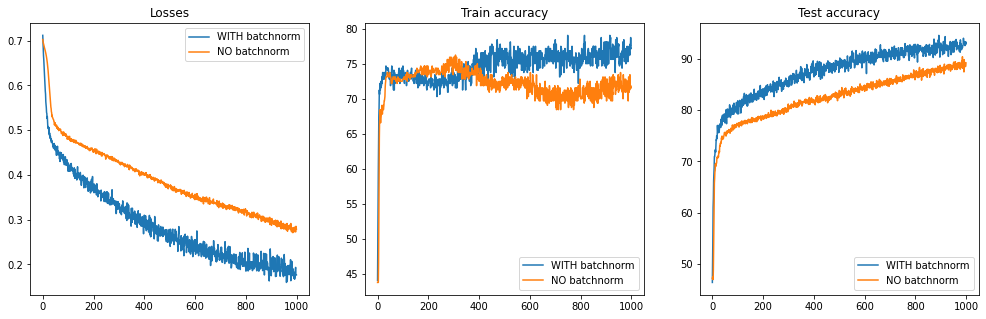

In [20]:
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(lossesWith,label='WITH batchnorm')
ax[0].plot(lossesNo,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAccWith,label='WITH batchnorm')
ax[1].plot(trainAccNo,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAccWith,label='WITH batchnorm')
ax[2].plot(testAccNo,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()